## Temporary Dataloader

OBS:
- Check if model needs RGB or BRG input
-  Remember to implement MagFace for Quality check before splitting**

In [48]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import cv2
from retinaface import RetinaFace
import random
import glob

# Set random seeds
torch.manual_seed(42)
random.seed(42)

#### Label association
Meget afhængigt af om vi laver face identification eller face verification 

**Ift face verification prøver vi her at opdele YLFW (og bagefter LFW) i train og test**

1. 80% af individuals til træning og 20% til test.
- Split herefter into pairs, hvor de har positive (1) og negative (0) pairs
- Både train og test set skal have equal amount of positive and negative pairs
2. Herefter preprocess pairs
3. Herefter træn FR models til at lære embeddings der kan distinguish 
4. Use trained model to perform *inference* on test set


##### YLFW split

In [241]:
# Read the text file for each ethnicity and split into image pairs and labels
# Ensure that identities are unique for each train and test set and that they are balanced on pos and neg pairs

meta_dir = '../data/raw/YLFW_bench/metadata/'
for pair_file in os.listdir(meta_dir):
    if len(pair_file) > 15: #gør det mere automatisk:))
        pairs = []
        with open(meta_dir+pair_file, 'r') as file: #join??
            for line in file:
                pair = line.strip().split()
                pairs.append((pair[0], pair[1], int(pair[2])))

        # Group pairs by identity
        identity_groups = {}
        for pair in pairs:
            identity = pair[0].split('/')[1]
            if identity not in identity_groups:
                identity_groups[identity] = []
            identity_groups[identity].append(pair)

        # Shuffle pairs within each identity group
        for identity in identity_groups:
            random.shuffle(identity_groups[identity])

        # Split each identity group into training and test sets
        train_pairs_identity = []
        test_pairs_identity = []
        for identity in identity_groups:
            # Calculate split index based on 80-20 ratio
            split_index = int(0.8 * len(identity_groups[identity]))
            
            # Split identity group into training and test sets
            train_pairs_identity.extend(identity_groups[identity][:split_index])
            test_pairs_identity.extend(identity_groups[identity][split_index:])

        # Shuffle the combined training and test sets
        random.shuffle(train_pairs_identity)
        random.shuffle(test_pairs_identity)

        # Write the train pairs to a file
        with open('train_{}.txt'.format(pair_file[:-4]), 'w') as train_file:
            for pair in train_pairs_identity:
                train_file.write(f"{pair[0]} {pair[1]} {pair[2]}\n")

        # Write the test pairs to a file
        with open('test_{}.txt'.format(pair_file[:-4]), 'w') as test_file:
            for pair in test_pairs_identity:
                test_file.write(f"{pair[0]} {pair[1]} {pair[2]}\n")


In [247]:
# List of input file paths
input_train_files = glob.glob("train_*")

# Output file path for concatenated file
output_train_file = 'train_YLFW_all_pairs.txt'

# Open the output file in write mode
with open(output_train_file, 'w') as outfile:
    # Iterate over each input file
    for input_file in input_train_files:
        # Open the input file in read mode
        with open(input_file, 'r') as infile:
            # Read the contents of the input file and write to the output file
            outfile.write(infile.read())
            # Optionally, add a newline character after each file
            outfile.write('\n')

In [248]:
# List of input file paths
input_test_files = glob.glob("test_*")

# Output file path for concatenated file
output_test_file = 'test_YLFW_all_pairs.txt'

# Open the output file in write mode
with open(output_test_file, 'w') as outfile:
    # Iterate over each input file
    for input_file in input_test_files:
        # Open the input file in read mode
        with open(input_file, 'r') as infile:
            # Read the contents of the input file and write to the output file
            outfile.write(infile.read())
            # Optionally, add a newline character after each file
            outfile.write('\n')

#### Dataloader class

In [259]:
# Data set class for load and preprocessing images

class FaceRecognitionDataset(Dataset):
    def __init__(self, data_dir, pairs_file, transform=None, RGB=True):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs_file = pairs_file
        self.pairs = self.read_pairs()
        self.RGB = RGB
        self.detector = RetinaFace.build_model()
        self.image_paths = self._get_image_paths()
        

    def _get_image_paths(self):
        image_paths = []
        for root, dirs, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith('.png') or file.endswith('.jpg'):
                    image_paths.append(os.path.join(root, file))
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]
        
        if self.data_dir + img1_path not in self.image_paths or \
        self.data_dir + img2_path not in self.image_paths:
            # Handle the case when image paths are not found
            # You can return None or raise an exception
            #raise FileNotFoundError("Image paths not found.")
            print("not there, moving on")
            
        if self.RGB: 
            color_chan = 'RGB'
        else:
            color_chan = 'BRG'
        
        face1 = RetinaFace.extract_faces(self.data_dir + img1_path, align=True)[0]
        face1 = Image.fromarray(face1).convert(color_chan)
        face2 = RetinaFace.extract_faces(self.data_dir + img2_path, align=True)[0]
        face2 = Image.fromarray(face2).convert(color_chan)

        # Apply transformations to each face (if any)
        if self.transform:
            img1 = self.transform(face1)
            img2 = self.transform(face2)

        return img1, os.path.basename(img1_path), img2, os.path.basename(img2_path), label

    
    def read_pairs(self):
        pairs = []
        with open(self.pairs_file, 'r') as file:
            for line in file:
                img1_path, img2_path, label = line.strip().split()
                if self.data_dir+img1_path in self.image_paths:
                    pairs.append((img1_path, img2_path, int(label)))
        return pairs


**Transformations**
1. Resnet requires RGB så derfor converter vi ikke til grayscale her.
2. **Experimentér med forskellige transformations** ift overfitting resultater

**Transformations MagFace** - TODO

In [260]:
# Example usage

data_dir = '../data/raw/YLFW_bench/data_p2'  # Update with data directory
pairs_file = 'test_YLFW_pairs_african.txt'
#pairs_file = 'test_YLFW_all_pairs.txt'
# Define transformations (examples..)
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Resize images to a fixed size required by magface
    transforms.RandomHorizontalFlip(), # Random horizontal flip for data augmentation
    transforms.RandomRotation(degrees=10),  # Random rotation for pose variation
    transforms.ColorJitter(brightness=0.02, contrast=0.02, saturation=0.2),  # Random brightness, contrast, saturation adjustment
    transforms.GaussianBlur(kernel_size=3),  # Random Gaussian blur
    transforms.ToTensor(),                  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0, 0, 0], std=[255, 255, 255])  # Normalize pixel values
])

dataset = FaceRecognitionDataset(data_dir, pairs_file, transform=transform)

**Transformations AdaFace**

In [ ]:
data_dir = '../data/raw/YLFW_bench/data_p2'  # Update with data directory
pairs_file = 'test_YLFW_pairs_african.txt'
#pairs_file = 'test_YLFW_all_pairs.txt'

# Define transformations (From AdaFace)
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Resize images to a fixed size required by magface
    transforms.RandomHorizontalFlip(), # Random horizontal flip for data augmentation
    transforms.RandomRotation(degrees=10),  # Random rotation for pose variation
    transforms.ColorJitter(brightness=0.02, contrast=0.02, saturation=0.2),  # Random brightness, contrast, saturation adjustment
    transforms.GaussianBlur(kernel_size=3),  # Random Gaussian blur
    transforms.ToTensor(),                  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0, 0, 0], std=[255, 255, 255])  # Normalize pixel values
])

dataset = FaceRecognitionDataset(data_dir, pairs_file, transform=transform)

#### Plot transformations

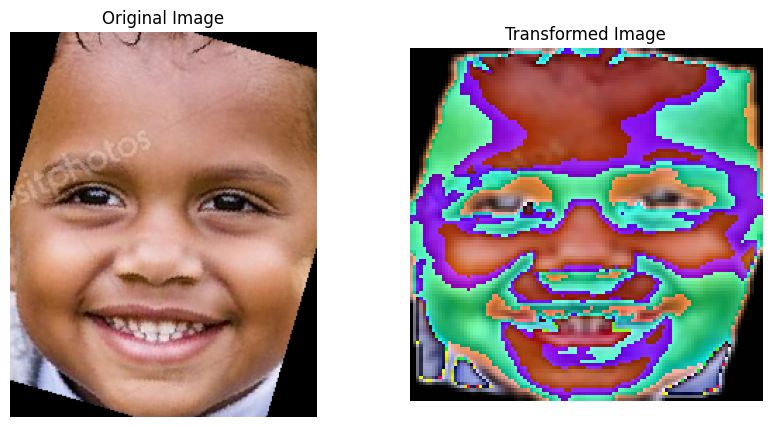

In [264]:
## TRANSFORMED IMAGE

# Access the same image from the original dataset
image1_trans, im_name_1, image2_trans, im_name_2 , label_original = dataset[0]  # Change the index if needed

# Convert the tensor image to a PIL Image
image_pil_trans = transforms.ToPILImage()(image1_trans)

## ORIGINAL IMAGE

# Define transformations for the original image (no transformations)
transform_original = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Create another instance of the dataset with no transformations
dataset_original = FaceRecognitionDataset(data_dir, pairs_file, transform=transform_original)

# Access the same image from the original dataset
image1_org, im_name_1, image2_org, im_name_2 , label_original = dataset_original[0]  # Change the index if needed

# Convert the tensor image to a PIL Image
image_pil_original = transforms.ToPILImage()(image1_org)

## PLOT 
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(image_pil_original)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the transformed image
axes[1].imshow(image_pil_trans)
axes[1].set_title('Transformed Image')
axes[1].axis('off')

plt.show()


#### Data loader in action

In [109]:
# Data loader ...
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Iterate over batches in the dataloader
for batch_idx, (images, image_names) in enumerate(dataloader):
    # Perform inference or training with the batch of images
    # Note: You would typically feed these images into your ArcFace model for training or inference
    print(f'Batch {batch_idx}: {image_names}')


Batch 0: ('Caucasian_604_20.png', 'Asian_386_42.png')
Batch 1: ('Asian_14_33.png', 'African_1_4.png')
Batch 2: ('Indian_224_0.png', 'Asian_386_27.png')
Batch 3: ('Caucasian_386_12.png', 'Indian_80_1.png')
Batch 4: ('Asian_386_2.png', 'Indian_80_0.png')
Batch 5: ('Asian_386_38.png', 'Indian_98_7.png')
Batch 6: ('Caucasian_386_9.png', 'Caucasian_204_63.png')
Batch 7: ('Asian_386_40.png', 'Asian_14_19.png')
Batch 8: ('African_0_0.png', 'Asian_386_3.png')
Batch 9: ('Asian_14_12.png', 'Caucasian_204_47.png')
Batch 10: ('Asian_14_6.png', 'Caucasian_204_27.png')
Batch 11: ('Caucasian_386_3.png', 'Asian_14_84.png')
Batch 12: ('Caucasian_604_4.png', 'Asian_386_30.png')
Batch 13: ('African_1_11.png', 'African_0_1.png')
Batch 14: ('Caucasian_386_6.png', 'Indian_98_12.png')
Batch 15: ('Caucasian_604_15.png', 'Asian_386_43.png')
Batch 16: ('Caucasian_204_1.png', 'Caucasian_204_25.png')
